Lorenzo Wormer, 1923031, 07.01.2021

# TMB: Exercize sheet 3

See handwritten notes for exercize 1. Notebook has to be run with Python 3.

In [1]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from enum import Enum
import pandas as pd
from functools import reduce
from itertools import product

## Common definitions

In [2]:
energy_map = {
    "H": 2,
    "P": 1
}

move_dict = {
    "E": (1, 0), 
    "S": (0, -1),
    "W": (-1, 0),
    "N": (0, 1)
}

In [3]:
def gen_random_chain(length):
    return "".join((rd.choice(list(energy_map.keys())) for i in range(0, length)))

In [4]:
def map_energies(chain):
    for i, c in enumerate(chain):
        if c not in energy_map: 
            raise Exception(f"Character {c} at sequence position {i} not supported")

    return np.array(list(map(lambda c: energy_map[c], list(chain))))


In [5]:
def calc_positions(move_seq):
    if move_seq[0] != next(iter(move_dict)):
        raise Exception(f"config sequence must always start with the default move (first move in move_dict, hence '{next(iter(move_dict))}')")

    moves = np.array([(0, 0), *(move_dict[m] for m in move_seq)])

    return np.cumsum(moves, axis=0)

In [6]:
def calc_adjacency_matrix(pos, check_overlap=False):
    n = len(pos)
    adj_matrix = np.zeros([n, n]) + np.diag([1]*(n-1), 1) + np.diag([1]*(n-1), -1)

    for i, r in enumerate(pos[0:-2]):
        diffs = pos[i+2:] - r
        taxicab_dists = np.sum(np.abs(diffs), axis=1)

        if check_overlap: 
            zeros = np.where(taxicab_dists < 1)
            if len(zeros[0]) != 0: 
                raise Exception(f"Overlap detected between position {str(i)} and positions {', '.join(map(str, zeros[0] + i + 2))}. Aborting.")

        taxicab_dists[taxicab_dists > 1] = 0
        adj_matrix[i, i+2:] = taxicab_dists
        adj_matrix[i+2:, i] = taxicab_dists

    return adj_matrix


In [7]:
def calc_total_energy(adj_matrix, energies):
    return np.sum((4 - np.sum(adj_matrix, axis=0)) * energies)

## Exercize 2

In [8]:
vertical_mirror_map = {
    "N": "S",
    "E": "E", 
    "S": "N", 
    "W": "W"
}

def remove_mirror_symmetries(configs):
    pure_configs = set(configs)
    for conf in configs:
        if conf not in pure_configs: continue
        
        conf_mirrored = "".join([vertical_mirror_map[c] for c in conf])
        pure_configs.remove(conf_mirrored)

    return list(pure_configs)

In [9]:
folded_configs_16 = remove_mirror_symmetries(pd.read_csv("./compact016.dat", header=None)[0].to_numpy())

In [62]:
def gen_unique_ground_state_16():
    
    ground_state = None

    for i in range(0, 1000):
        chain = gen_random_chain(16)
        energies = map_energies(chain)

        all_total_E = np.array(
            [
                calc_total_energy(
                    calc_adjacency_matrix(
                        calc_positions(conf)
                    ), 
                    energies
                ) 
                for conf in folded_configs_16
            ]
        )

        min_indices = np.where(all_total_E == np.amin(all_total_E))[0]

        if len(min_indices) == 1:
            config = folded_configs_16[min_indices[0]]
            pos = calc_positions(config)
            diam = np.linalg.norm(pos[-1] - pos[0])
            E_tot = all_total_E[min_indices[0]]

            ground_state = (chain, config, diam, E_tot)
            break

    return ground_state

In [67]:
unique_folded_state = gen_unique_ground_state_16()

unique_folded_state

('HHPHPPPPPHHHPPHP', 'ENWWSSSENESENNN', 2.23606797749979, 19.0)

In [1]:
# Use nicest one:
unique_folded_state = ('HHPHPPPPPHHHPPHP', 'ENWWSSSENESENNN', 2.23606797749979, 19.0)

## Exercizes 3 and 4

In [12]:
def pivot_config_at_index(pos, adj_matrix, index, direction="counter-clockwise"):

    const_pos = pos[:index]

    rotated_pos = np.matmul(
            pos[index:] - pos[index],
            np.array([[0, 1], [-1, 0]]) * (-1 if direction == "clockwise" else 1)
        ) + pos[index]

    new_pos = np.concatenate([const_pos, rotated_pos], axis=0)

    if len(rotated_pos) > 0 and np.array_equal(const_pos[-1], rotated_pos[0]): 
        raise Exception("intersection directly at pivot")
    
    matrix_update = np.sum(
        list(
            map(
                lambda x: np.abs(np.subtract.outer(*x)), 
                (
                    (const_pos[:, i], rotated_pos[:, i]) for i in range(0, 2)
                )
            )
        ), 
        axis=0
    )

    zeros = np.where(matrix_update < 1)
    if len(zeros[0]) != 0: 
        raise Exception(f"Overlaps at {', '.join(map(lambda x: f'({x[0]}, {x[1]})', zeros))}")


    matrix_update[matrix_update > 1] = 0

    new_matrix = np.copy(adj_matrix)
    new_matrix[:index, index:] = matrix_update
    new_matrix[-index:, :-index] = matrix_update

    return new_pos, new_matrix

In [13]:
def propose_next_state(pos, adj_matrix):
    
    next_state = None

    while(next_state is None):
        rand_index = rd.choice(range(1, len(pos)))
        try:
            next_state = pivot_config_at_index(
                pos, 
                adj_matrix, 
                rand_index,
                direction=rd.choice(["clockwise", "counter-clockwise"])
            )
        except:
            continue

    return next_state

In [14]:
def calc_transition_probability(delta_E, T):
    return np.exp(- 1 / T * delta_E)

In [15]:
def MCMC_timestep(pos, adj_matrix, energies, E_tot, T):

    pos_new, adj_matrix_new = propose_next_state(pos, adj_matrix)

    E_tot_new = calc_total_energy(adj_matrix_new, energies)
    trans_prob = calc_transition_probability(E_tot_new - E_tot, T)

    return (pos_new, adj_matrix_new, E_tot_new) if rd.random() < trans_prob else (pos, adj_matrix, E_tot)

In [16]:
def calc_end_to_end_dist(pos, **kwargs):
    return np.linalg.norm(pos[-1] - pos[0])

In [17]:
def gen_linear_T_profile(T_start, T_end):
    return lambda i, n: T_start + (T_end - T_start) / n * i

In [27]:
def run_MCMC(chain, initial_config, state_reducer, T_profile, n=1000):

    energies = map_energies(chain)

    pos = calc_positions(initial_config)
    adj_matrix = calc_adjacency_matrix(pos)
    E_tot = calc_total_energy(adj_matrix, energies)

    trace = [state_reducer(pos=pos, adj_matrix=adj_matrix, E_tot= E_tot, i=0)]

    for i in range(1, n):
        pos, adj_matrix, E_tot = MCMC_timestep(pos, adj_matrix, energies, E_tot, T_profile(i, n))
        trace.append(state_reducer(pos=pos, adj_matrix=adj_matrix, E_tot= E_tot, i=0))

    return trace

### Exercize 3

In [76]:
trace = run_MCMC(unique_folded_state[0], unique_folded_state[1], calc_end_to_end_dist, lambda i, n: 1.5)

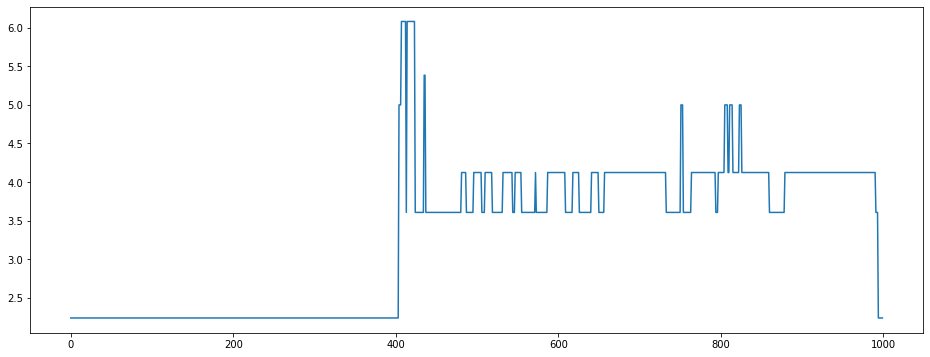

In [77]:
plt.figure(figsize=(16, 6))
plt.plot(trace)

### Exercize 4

In [78]:
trace = run_MCMC(unique_folded_state[0], "E"*15, calc_end_to_end_dist, gen_linear_T_profile(2, 1), n=10000)

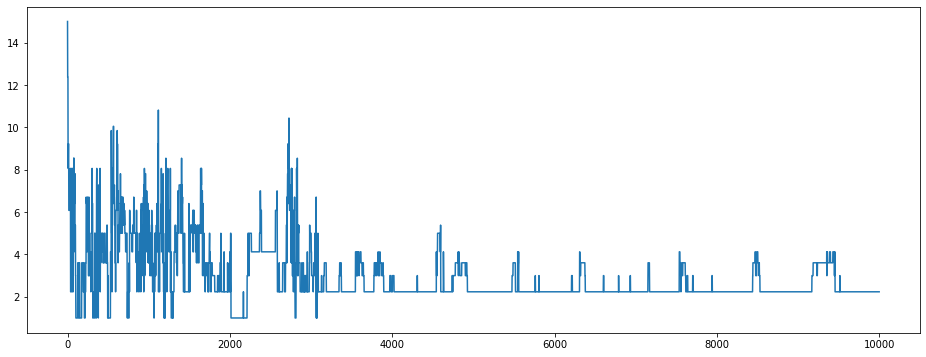

In [79]:
plt.figure(figsize=(16, 6))
plt.plot(trace)